# Visualize company data and results

Purpose of the notebook: prepare company data and inference results for the analysis (plots, summary statistics)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import ast
from scipy.stats import ttest_ind

# A) Company data
Include company info from LSEG to info from SRN
- retrieved all company data with the help of ISIN code from LSEG based on the companies from esrs_reports.xlsx
- merge them with SRN information

In [2]:
company_data = pd.read_excel(
    "lseg_company_data.xlsx",
    na_values=["Unable to resolve some identifier(s).", "NULL"])
print(len(company_data))

489


In [3]:
# drop rows where ISIN is missing
company_data = company_data.dropna(subset=['ISIN'])
print(len(company_data))

482


In [4]:
# look if there are duplicate ISINs
company_data[company_data.duplicated(subset=['ISIN'], keep=False)]

,Company Common Name,Company Market Capitalization,ISIN,RIC,Country of Headquarters,GICS Sector Name,Social Pillar Score,Social Pillar Score Grade,Workforce Score Grade,Workforce Score,...,Company Green Revenue Percentage,Estimated EU Taxonomy Aligned Company Green Revenue Percentage,Total Assets - Mean,Number of Employees,ESG Score Grade,ESG Score,ESG Combined Score Grade,ESG Combined Score,CSR Sustainability Reporting Score,Number of Employees from CSR reporting


In [5]:
### only look at companies where inference was run

# read in all_results.jsonl
all_results = pd.read_json("all_results.jsonl", lines=True)
all_results = all_results[~all_results.duplicated(subset=['report_id'], keep='first')] # for 10 reports inference was run twice
# delete reports that have missings in the inference
missings_rep = ['Genmab_2024', 'Alk-Abello_2024', 'Repsol_2024', 'K+S_2024', 'TeliaCompany_2024', 'HapagLloyd_2024', 'Outokumpu_2024', 'SSAB_2024', 'TGSNOPECGeophysicalCo_2024']
all_results = all_results[~all_results['report_id'].isin(missings_rep)]
print(len(all_results))

# read in srn_infos
srn_infos = pd.read_excel("esrs_reports.xlsx")

# keep only rows where report_id is in all_results
srn_infos = srn_infos[srn_infos['report_id'].isin(all_results['report_id'])]
print(len(srn_infos))

465
465


In [6]:
# join srn_infos with company_data on isin
merged_info = srn_infos.merge(company_data, left_on='isin', right_on='ISIN', how='left')
print(len(merged_info))

465


In [7]:
# when Number of Employees from CSR reporting is missing, fill it with Number of Employees from LSEG
merged_info['number_employees'] = merged_info['Number of Employees  from CSR reporting'].fillna(merged_info['Number of Employees'])
print("Number of missings in employee number", merged_info['number_employees'].isna().sum())

# drop columns 'Number of Employees  from CSR reporting' and 'Number of Employees'
merged_info = merged_info.drop(columns=['Number of Employees  from CSR reporting', 'Number of Employees'])

# drop all companys with less than 750 employees
merged_info = merged_info[merged_info['number_employees'] >= 750]
print("Number of companies with 750 employees or more:", len(merged_info))

Number of missings in employee number 0
Number of companies with 750 employees or more: 464


## 1. Control for mismatches SRN and LSEG info
### 1.1 Country of the company

In [8]:
# print all rows where country and Country of Headquarters are not the same
mismatched_country = merged_info[merged_info['country'] != merged_info['Country of Headquarters']]

# keep only relevant columns: Company Name, country, Country of Headquarters, Incorp. Region Code
mismatched_country = mismatched_country[['company', 'Company Common Name', 'ISIN', 'country', 'Country of Headquarters', 'Incorp. Region Code']]

print(mismatched_country)

                           company  \
35                          Airbus   
58                     Tatra banka   
72                       Ferrovial   
85                             IAG   
95                  EDP Renováveis   
98                           Iveco   
232  Vseobecna Uverova Banka (VUB)   
235               Cementir Holding   
274    BRD Groupe Societe Generale   
299                Ariston Holding   
302        Bank of Cyprus Holdings   
339                   Amadeus Fire   
364               Odfjell Drilling   
369                  RHI Magnesita   
391               Technip Energies   

                              Company Common Name          ISIN      country  \
35                                      Airbus SE  NL0000235190       France   
58                                 Tatra Banka as  SK1110001502     Slovakia   
72                                   Ferrovial SE  NL0015001FS8        Spain   
85   International Consolidated Airlines Group SA  ES0177542018        

found mistake:
company: Ferrovial SE ISIN: NL0015001FS8 --> Netherlands (not Spain)

In [9]:
# for ISIN: NL0015001FS8 change country from Spain to Netherlands in merged_info
merged_info.loc[merged_info['ISIN'] == 'NL0015001FS8', 'country'] = 'Netherlands'

print(merged_info[merged_info['ISIN'] == 'NL0015001FS8'])

      company          isin      country publication_date auditor  \
72  Ferrovial  NL0015001FS8  Netherlands       2025-02-28      EY   

                                                 link  \
72  https://static-iai.ferrovial.com/wp-content/up...   

                          SASB_industry       report_id Company Common Name  \
72  Engineering & Construction Services  Ferrovial_2024        Ferrovial SE   

    Company Market Capitalization  ... Incorp. Region Code  \
72                    30026.34942  ...                 NLD   

   Company Green Revenue Percentage  \
72                           6.9888   

   Estimated EU Taxonomy Aligned Company Green Revenue Percentage  \
72                                             3.0351               

   Total Assets - Mean  ESG Score Grade  ESG Score ESG Combined Score Grade  \
72             26033.4                A  88.466182                        A   

    ESG Combined Score CSR Sustainability Reporting Score  number_employees  
72     

In [10]:
# drop unnecessary columns
merged_info = merged_info.drop(columns=['Country of Headquarters', 'Incorp. Region Code'])

### 1.2 Company names

In [11]:
# look at all mismatches in the names
    # 1. prepare standardizes names (remove sa, se, nv, ag, a/s)

def standardize_name(name):
    name = name.lower()
    name = name.replace(" sa", "").replace(" se", "").replace(" nv", "").replace(" ag", "").replace(" a/s", "").replace(" oyj", "").replace(" ab", "").replace(" abp", "").replace(" plc", "").replace(" spa", "").replace(" asa", "").replace(" nyrt", "").replace(" holding", "").replace(" group", "")
    name = name.strip()
    return name

# compare standardized "company" and "Company Common Name"
merged_info['srn_company_std'] = merged_info['company'].apply(standardize_name)
merged_info['lseg_company_std'] = merged_info['Company Common Name'].apply(standardize_name)
mismatched_names = merged_info[merged_info['srn_company_std'] != merged_info['lseg_company_std']]
mismatched_names = mismatched_names[['ISIN', 'link', 'company', 'Company Common Name', 'srn_company_std', 'lseg_company_std']]
print(mismatched_names)

             ISIN                                               link  \
2    DK0060079531  https://investor.dsv.com/static-files/d34d3dfc...   
3    DK0061804697  https://www.lundbeck.com/content/dam/lundbeck-...   
4    DK0061539921  https://www.vestas.com/content/dam/vestas-com/...   
11   DK0060094928  https://cdn.orsted.com/-/media/annual2024/orst...   
12   DK0010244425  https://attachment.news.eu.nasdaq.com/a55930e6...   
..            ...                                                ...   
448  GRS323003012  https://www.eurobank.gr/-/media/eurobank/omilo...   
452  DE0006083405  https://www.hornbach-holding.de/media/document...   
453  CH0042615283  https://ir-corporate.docmorris.com/media/docum...   
460  ES0173093024  https://www.redeia.com/sites/default/files/pub...   
462  FR0000054470  https://staticctf.ubisoft.com/8aefmxkxpxwl/2jO...   

                                  company  \
2                           DSV Panalpina   
3                                Lundbeck   


found mismatches in Company: Cargotec, ISIN: FI4000571013

In [12]:
# drop row of ISIN: FI4000571013
merged_info = merged_info[merged_info['ISIN'] != 'FI4000571013']

# drop unnecessary columns
merged_info = merged_info.drop(columns=['srn_company_std', 'lseg_company_std', 'company'])
# rename column 'Company Common Name' to 'company_name'
merged_info = merged_info.rename(columns={'Company Common Name': 'company_name'})

print(len(merged_info))

463


## 2. Look at missings

In [13]:
# for every column print number of missings
for column in merged_info.columns:
    num_missing = merged_info[column].isna().sum()
    print(f"'{column}' has {num_missing} missing values")

'isin' has 0 missing values
'country' has 0 missing values
'publication_date' has 0 missing values
'auditor' has 0 missing values
'link' has 0 missing values
'SASB_industry' has 0 missing values
'report_id' has 0 missing values
'company_name' has 0 missing values
'Company Market Capitalization' has 2 missing values
'ISIN' has 0 missing values
'RIC' has 0 missing values
'GICS Sector Name' has 0 missing values
'Social Pillar Score' has 0 missing values
'Social Pillar Score Grade' has 0 missing values
'Workforce Score Grade' has 0 missing values
'Workforce Score' has 0 missing values
'Company Green Revenue Percentage' has 36 missing values
'Estimated EU Taxonomy Aligned Company Green Revenue Percentage' has 51 missing values
'Total Assets - Mean' has 39 missing values
'ESG Score Grade' has 0 missing values
'ESG Score' has 0 missing values
'ESG Combined Score Grade' has 0 missing values
'ESG Combined Score' has 0 missing values
'CSR Sustainability Reporting Score' has 0 missing values
'num

In [14]:
# drop rows where Company Market Capitalization is missing
merged_info = merged_info.dropna(subset=['Company Market Capitalization'])
print(len(merged_info))

461


# B) Company descriptives

### 1. Per industry & country

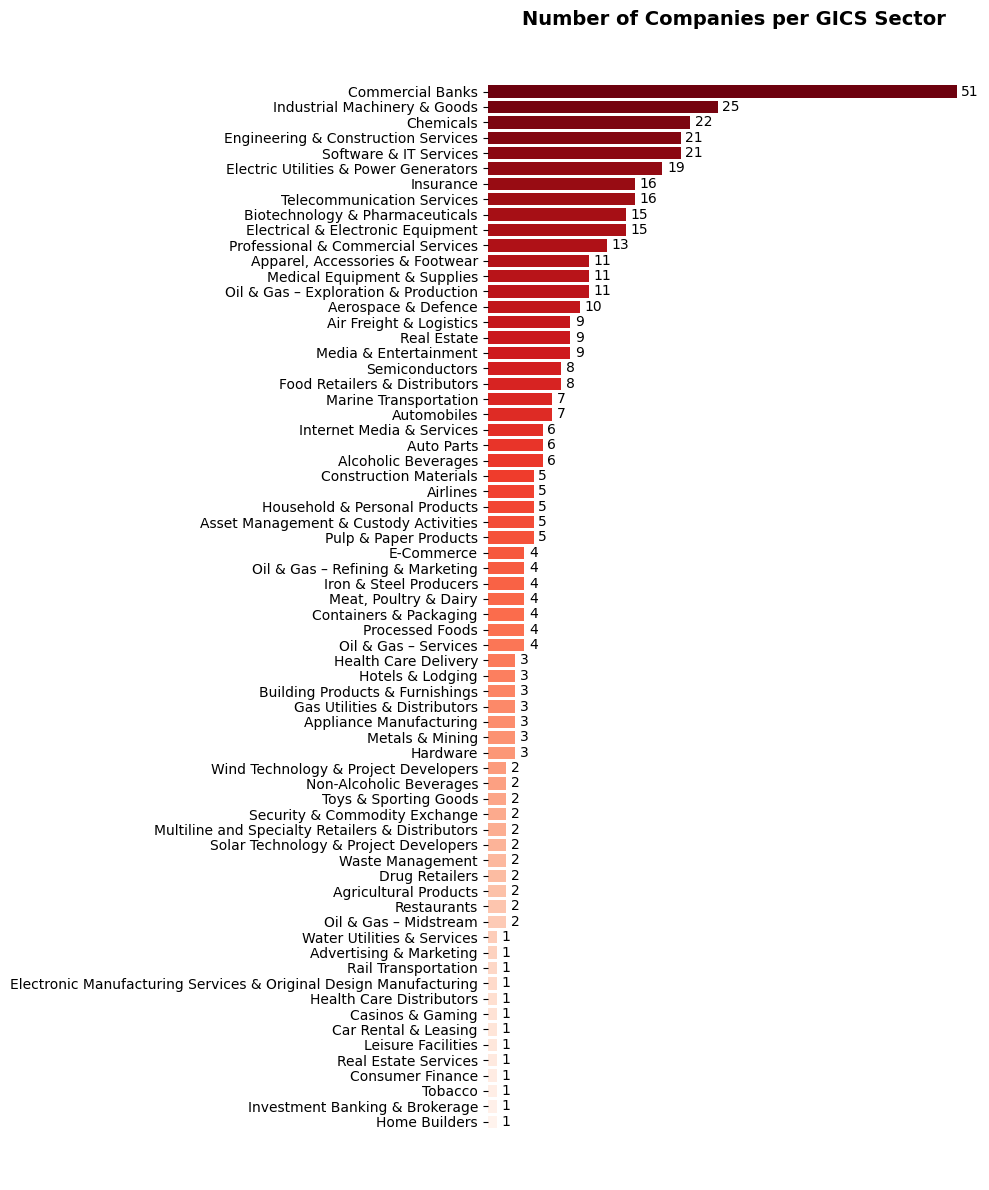

In [15]:
# Count companies per sector
sector_counts = (
    merged_info["SASB_industry"]
    .value_counts()
    .reset_index()
)
sector_counts.columns = ["Sector", "Count"]

# Sort sectors so highest count is first
sector_counts = sector_counts.sort_values("Count", ascending=True).reset_index(drop=True)

# Create color palette from light to dark red (highest count = darkest red)
colors = sns.color_palette("Reds", n_colors=len(sector_counts))

# Assign colors based on sorted order
color_map = dict(zip(sector_counts["Sector"], colors))
bar_colors = sector_counts["Sector"].map(color_map)

# Plot (horizontal bar chart)
fig, ax = plt.subplots(figsize=(10, 12))
bars = ax.barh(
    y=sector_counts["Sector"],
    width=sector_counts["Count"],
    color=bar_colors
)

# Add counts at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{int(width)}",
            va="center", ha="left", fontsize=10)

# Style
ax.set_title("Number of Companies per GICS Sector", fontsize=14, weight="bold")
ax.set_xlabel("")  # remove x-axis label
ax.xaxis.set_visible(False)  # hide x-axis ticks and labels
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(False)  # remove grid lines

plt.tight_layout()
plt.show()

Sustainable Industry Classification System (SICS), was developed by the Sustainability Accounting Standards Board (SASB) to group companies into sectors with comparable exposure to sustainability-related risks and opportunities. Due to the sample size the companies are very fractured across the sectors. Therefore, I am differntiating with the GICS Sectors. 

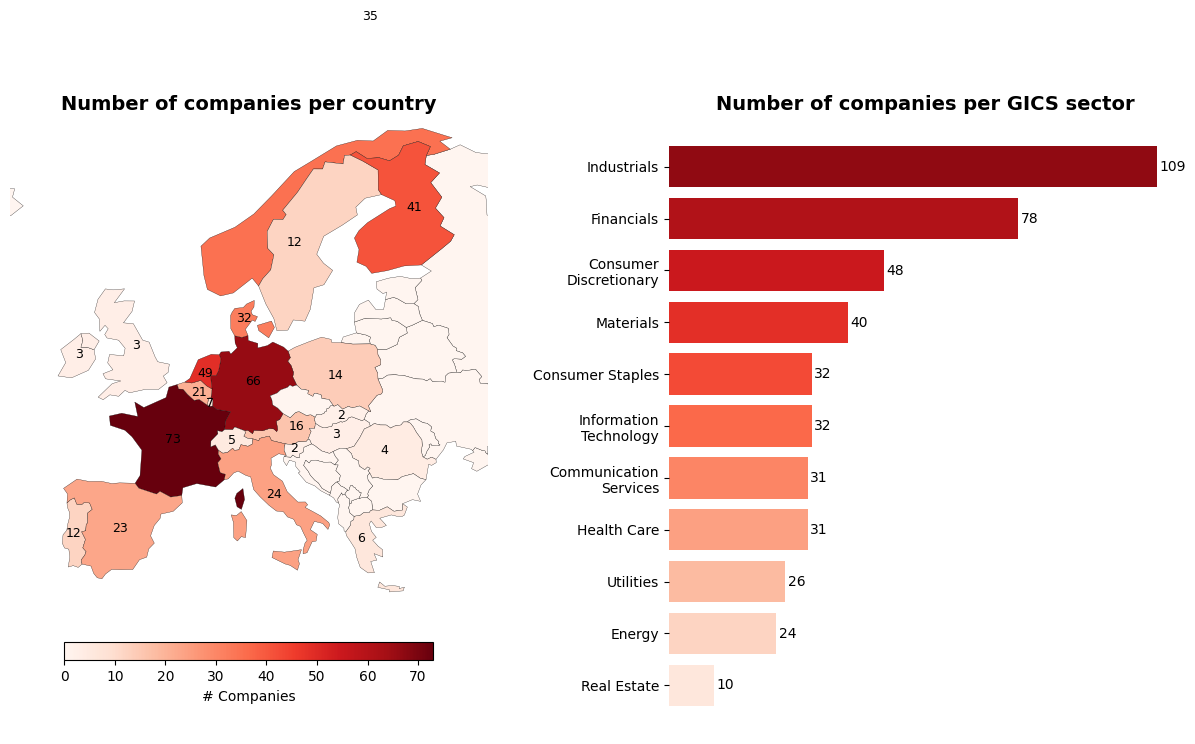

In [16]:
import textwrap
import geopandas as gpd

# --- Map preparation ---
world = gpd.read_file("earth/ne_110m_admin_0_countries.shp")
europe = world[world['CONTINENT'] == 'Europe']

country_counts = merged_info["country"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

europe_counts = europe.merge(country_counts, left_on="NAME", right_on="country", how="left")
europe_counts["count"] = europe_counts["count"].fillna(0)

# --- Sector preparation ---
sector_counts = (
    merged_info["GICS Sector Name"]
    .value_counts()
    .reset_index()
)
sector_counts.columns = ["Sector", "Count"]

sector_counts = sector_counts.sort_values("Count", ascending=True).reset_index(drop=True)

colors = sns.color_palette("Reds", n_colors=len(sector_counts))
color_map = dict(zip(sector_counts["Sector"], colors))
bar_colors = sector_counts["Sector"].map(color_map)

# --- Combined figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1.2, 1]})

# --- Left: Map ---
cmap = cm.Reds
norm = mcolors.Normalize(vmin=europe_counts["count"].min(), vmax=europe_counts["count"].max())

europe_counts.plot(
    column='count',
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=0.2,
    ax=ax1,
    legend=True,
    legend_kwds={
        "label": "# Companies",
        "orientation": "horizontal",
        "shrink": 0.6,
        "pad": 0.02
    },
    missing_kwds={
        "color": "white",
        "edgecolor": "black"
    }
)

for idx, row in europe_counts.iterrows():
    if row["count"] > 0:
        x, y = row.geometry.representative_point().coords[0]
        ax1.text(x, y, int(row["count"]), ha="center", va="center", fontsize=9, color="black")

ax1.set_xlim(-15, 35)
ax1.set_ylim(32, 72)
ax1.axis('off')
ax1.set_title("Number of companies per country", fontsize=14, weight="bold")

# --- Right: Bar chart ---

# Wrap sector names (e.g., break after ~20 chars)
sector_counts["Sector_wrapped"] = sector_counts["Sector"].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=20))
)

# Right: Bar chart with wrapped labels
bars = ax2.barh(
    y=sector_counts["Sector_wrapped"],
    width=sector_counts["Count"],
    color=bar_colors
)

for bar in bars:
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"{int(width)}",
             va="center", ha="left", fontsize=10)

ax2.set_title("Number of companies per GICS sector", fontsize=14, weight="bold")
ax2.set_xlabel("")
ax2.xaxis.set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(False)


In [17]:
# prepare list of companies by name and country, grouped by SICS sector

# Make sure we have only relevant columns
subset = merged_info[["company_name", "country", "GICS Sector Name"]].copy()

# Sort by sector, then by country, then by company
subset = subset.sort_values(by=["GICS Sector Name", "country", "company_name"])

# export subset to excel
subset.to_excel("company_list.xlsx", index=False)

## 2. Descriptives of used variables

In [18]:
# descriptive table with min, max, mean, median, std about: Company Market Capitalization, Number of Employees, social pillar score, workforce score
desc_table = merged_info[['Company Market Capitalization', 'number_employees', 'Social Pillar Score', 'Workforce Score']].describe()
print(desc_table)

       Company Market Capitalization  number_employees  Social Pillar Score  \
count                     461.000000        461.000000           461.000000   
mean                    16707.187057      33958.978308            71.833548   
std                     36365.180169      64707.362461            15.614357   
min                        18.662197        775.000000            15.110231   
25%                      1406.051654       3704.000000            62.195987   
50%                      4644.790682      11219.000000            74.107245   
75%                     14771.996852      32321.000000            83.484192   
max                    317967.150350     614082.000000            97.676076   

       Workforce Score  
count       461.000000  
mean         76.308692  
std          19.484323  
min           9.327217  
25%          65.798611  
50%          80.912162  
75%          92.045455  
max          99.828767  


In [19]:
# Select the columns you want
cols = [
    "Company Market Capitalization",
    "Total Assets - Mean",
    "number_employees",
    "ESG Score",
    "ESG Combined Score",
    "Social Pillar Score",
    "Workforce Score",
    "CSR Sustainability Reporting Score",
    "Company Green Revenue Percentage",
    "Estimated EU Taxonomy Aligned Company Green Revenue Percentage",

]

# Calculate descriptive statistics
desc_table = pd.DataFrame({
    "Min": merged_info[cols].min(),
    "Max": merged_info[cols].max(),
    "Mean": merged_info[cols].mean(),
    "Median": merged_info[cols].median(),
    "Std Dev": merged_info[cols].std(),
    "Total Observations": merged_info[cols].count(),
})


# Optional: Rename index to nice format
desc_table.index.name = "Variable"

# round all values to 2 decimal places
desc_table = desc_table.round(2)

# Display table
desc_table

# save as an excel file
desc_table.to_excel("descriptive_statistics.xlsx")

# C) Inference results

In [20]:
# read in all_results.jsonl
all_results = pd.read_json("all_results.jsonl", lines=True)
all_results = all_results[~all_results.duplicated(subset=['report_id'], keep='first')] # for 10 reports inference was run twice
print(len(all_results))

474


In [21]:
# keep only report_ids that are in merged_info
all_results = all_results[all_results['report_id'].isin(merged_info['report_id'])]
print(len(all_results))

461


In [22]:
print(all_results.head())

           report_id        company  row_index  \
0    Netcompany_2024     Netcompany          0   
1          Tryg_2024           Tryg          1   
2  DSVPanalpina_2024  DSV Panalpina          2   
3      Lundbeck_2024       Lundbeck          3   
4        Vestas_2024         Vestas          4   

                                              result  
0  {'S1_A1': {'verdict': 'NO', 'analysis': '[[NO]...  
1  {'S1_A1': {'verdict': 'NO', 'analysis': '[[NO]...  
2  {'S1_A1': {'verdict': 'NO', 'analysis': '[[NO]...  
3  {'S1_A1': {'verdict': 'YES', 'analysis': '[[YE...  
4  {'S1_A1': {'verdict': 'NO', 'analysis': '[[NO]...  


In [23]:
binary_data = []

for _, row in all_results.iterrows():
    report = row["report_id"]
    
    # result column is a string of dict → convert safely
    results_dict = row["result"]
    
    for indicator, info in results_dict.items():
        verdict = info.get("verdict", None)   # None if missing
        analysis = info.get("analysis", None)
        
        # Assign binary disclosure
        if verdict == "YES":
            disclosure_status = 1
        elif verdict == "NO":
            disclosure_status = 0
        else:
            disclosure_status = np.nan
            print(f"Missing verdict in report {report}, indicator {indicator}")
            print("Verdict:", verdict)
            print("Analysis:", analysis, "\n")
        
        # Define topic (e.g. S1_A1 → A, S1_B3 → B)
        topic = indicator[3]
        
        binary_data.append({
            "report_id": report,
            "indicator": indicator,
            "topic": topic,
            "disclosure_status": disclosure_status
        })

# Create disclosure matrix DataFrame
df_disclosure = pd.DataFrame(binary_data)

In [24]:
# drop all results where inference has a missing verdict
missings_rep = ['Genmab_2024', 'Alk-Abello_2024', 'Repsol_2024', 'K+S_2024', 'TeliaCompany_2024', 'HapagLloyd_2024', 'Outokumpu_2024', 'SSAB_2024', 'TGSNOPECGeophysicalCo_2024']

df_disclosure = df_disclosure[~df_disclosure['report_id'].isin(missings_rep)]
# count number of unique report_ids
print("Number of reports after dropping missings:", df_disclosure['report_id'].nunique())


Number of reports after dropping missings: 461


In [25]:
# --- 1. Report-Level Disclosure ---
report_disclosure = (
    df_disclosure
    .groupby("report_id")["disclosure_status"]
    .mean()
    .mul(100)
    .reset_index(name="report_disclosure")
)

# --- 2. Topic-Level Disclosure ---
topic_disclosure = (
    df_disclosure
    .groupby(["report_id", "topic"])["disclosure_status"]
    .mean()
    .mul(100)
    .reset_index()
    .pivot(index="report_id", columns="topic", values="disclosure_status")
)

# Rename columns to e.g. A_disclosure, B_disclosure, ...
topic_disclosure = topic_disclosure.add_suffix("_disclosure").reset_index()

# --- 3. Combine into one aggregated dataset ---
aggregated_disclosure = report_disclosure.merge(topic_disclosure, on="report_id", how="left")

# Ergebnis anschauen
print(aggregated_disclosure.head())


                      report_id  report_disclosure  A_disclosure  \
0  (M6)MetropoleTelevision_2024          38.461538         43.75   
1                  ABInBev_2024          32.307692         43.75   
2                  ABNAmro_2024          47.692308         43.75   
3             AGFA-Gevaert_2024           0.000000          0.00   
4                  AIXTRON_2024          55.384615         43.75   

   B_disclosure  C_disclosure  D_disclosure  E_disclosure  F_disclosure  \
0          25.0     27.272727     50.000000          60.0     36.363636   
1          25.0     18.181818     33.333333          40.0     45.454545   
2          50.0     27.272727     75.000000          80.0     54.545455   
3           0.0      0.000000      0.000000           0.0      0.000000   
4          50.0     36.363636     75.000000          80.0     90.909091   

   G_disclosure  
0     16.666667  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  


In [26]:
# print the analysis for all reports with 0 report_disclosure and look at the analysis
zero_reports = aggregated_disclosure[aggregated_disclosure['report_disclosure'] == 0.0]

zero_reports_analysis = all_results[all_results['report_id'].isin(zero_reports['report_id'])]

looked at the inference results, no anomalites were obvious

### 1. Descriptives all companies

In [27]:
topic_labels = {
    "A_disclosure": "A: management and disclosure of material impacts, risks and opportunities",
    "B_disclosure": "B: material risks and opportunities arising from dependencies on own workforce",
    "C_disclosure": "C: human rights practices, risks and incidents",
    "D_disclosure": "D: processes and policies for engaging with own workforce about impacts",
    "E_disclosure": "E: policies on non-discrimination, diversity and inclusion",
    "F_disclosure": "F: approaches to remediate negative impacts and channels to raise concerns",
    "G_disclosure": "G: social protection coverage"
}

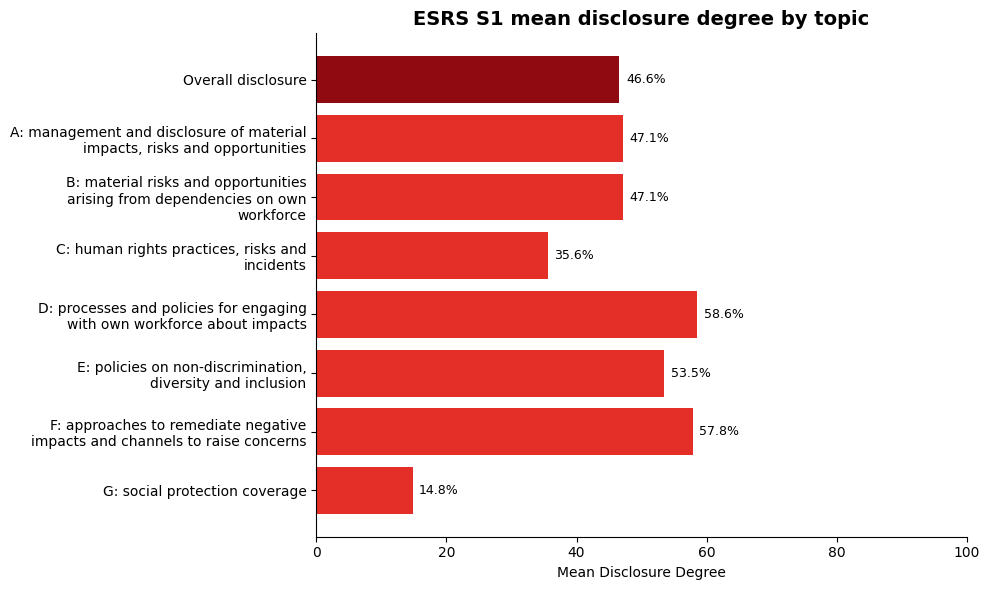

In [28]:
# --- calculate means ---
mean_values = aggregated_disclosure.mean(numeric_only=True)

# --- split overall and topics ---
overall_value = mean_values["report_disclosure"]
topic_values = mean_values[topic_labels.keys()]


# --- add overall and topics ---
plot_values = [overall_value] + list(topic_values.values)
plot_labels = ["Overall disclosure"] + [topic_labels[col] for col in topic_values.index]

# --- labels in two lines ---
wrapped_labels = [textwrap.fill(label, width=40) for label in plot_labels]

# --- define colors ---
colors = ["#900A12"] + ["#E32F27"] * len(topic_values)

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(wrapped_labels, plot_values, color=colors)

# --- add numbers on bars ---
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%", va="center", ha="left", fontsize=9)

# --- layout ---
ax.set_xlim(0, 100)
ax.set_xlabel("Mean Disclosure Degree")
ax.set_title("ESRS S1 mean disclosure degree by topic", fontsize=14, weight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


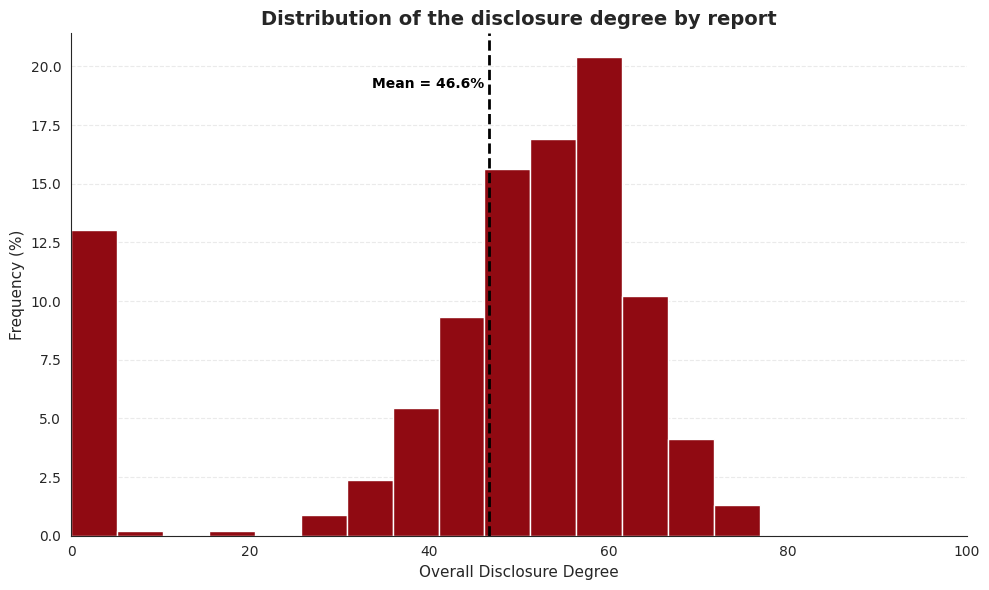

In [45]:
# --- Data ---
data = aggregated_disclosure["report_disclosure"].dropna()

# --- Style setup to match the bar chart ---
sns.set_style("white")  # remove gray Seaborn background

fig, ax = plt.subplots(figsize=(10, 6))

# --- Histogram with relative frequency in % ---
sns.histplot(
    data,
    bins=15,
    stat="percent",      # show relative frequencies
    color="#900A12",     # same as overall disclosure color
    alpha=1.0,
    edgecolor="white",   # clean bar separation
    ax=ax
)
# --- add the mean ---
mean_value = data.mean()
ax.axvline(mean_value, color="black", linestyle="--", linewidth=2)
ax.text(
    mean_value - 13,           
    ax.get_ylim()[1] * 0.9,   # position at ~90% of the y-axis height
    f"Mean = {mean_value:.1f}%", 
    color="black", 
    fontsize=10,
    va="center",
    ha="left",
    fontweight="bold"
)

# --- Layout and aesthetics to match ---
ax.set_xlim(0, 100)
ax.set_xlabel("Overall Disclosure Degree", fontsize=11)
ax.set_ylabel("Frequency (%)", fontsize=11)
ax.set_title("Distribution of the disclosure degree by report", fontsize=14, weight="bold")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_facecolor("white")

plt.tight_layout()
plt.show()

In [30]:
# --- Define the disclosure columns ---
disclosure_cols = ["report_disclosure", "A_disclosure", "B_disclosure", "C_disclosure",
                   "D_disclosure", "E_disclosure", "F_disclosure", "G_disclosure"]

n_reports = len(aggregated_disclosure)
print("Number of reports:", n_reports)

# --- Compute statistics ---
summary_table = pd.DataFrame({
    "Mean": aggregated_disclosure[disclosure_cols].mean(),
    "Std": aggregated_disclosure[disclosure_cols].std(),
    "Min": aggregated_disclosure[disclosure_cols].min(),
    "% (of zero)": (aggregated_disclosure[disclosure_cols].eq(0).sum() / n_reports * 100),
    "Max": aggregated_disclosure[disclosure_cols].max()
})

# --- Round values for readability ---
summary_table = summary_table.round(2)

# --- Rename the index for nicer display ---
summary_table.index = [
    "Overall disclosure",
    "A: management and disclosure of material impacts, risks and opportunities",
    "B: material risks and opportunities arising from dependencies on own workforce",
    "C: human rights practices, risks and incidents",
    "D: processes and policies for engaging with own workforce about impacts",
    "E: policies on non-discrimination, diversity and inclusion",
    "F: approaches to remediate negative impacts and channels to raise concerns",
    "G: social protection coverage"
]

# --- Display table ---
display(summary_table)

# --- Save as an excel file ---
summary_table.to_excel("disclosure_summary.xlsx")


Number of reports: 461


,Mean,Std,Min,% (of zero),Max
Overall disclosure,46.60,20.11,0.0,12.58,76.92
"A: management and disclosure of material impacts, risks and opportunities",47.14,21.46,0.0,12.80,87.50
B: material risks and opportunities arising from dependencies on own workforce,47.13,29.74,0.0,15.62,100.00
"C: human rights practices, risks and incidents",35.59,18.36,0.0,13.67,90.91
D: processes and policies for engaging with own workforce about impacts,58.55,28.39,0.0,12.80,100.00
"E: policies on non-discrimination, diversity and inclusion",53.49,26.92,0.0,13.23,100.00
F: approaches to remediate negative impacts and channels to raise concerns,57.84,26.38,0.0,13.02,100.00
G: social protection coverage,14.79,23.29,0.0,60.95,83.33


In [31]:
# --- Calculate disclosure rate per indicator ---
indicator_summary = (
    df_disclosure.groupby("indicator")["disclosure_status"]
    .mean() * 100  # convert to percentage
)

# --- Sort indicators by disclosure rate ---
indicator_summary = indicator_summary.sort_values(ascending=False)

# --- Top 5 most disclosed indicators ---
top5_disclosed = indicator_summary.head(5).reset_index()
top5_disclosed.columns = ["Indicator", "Disclosure (%)"]

# --- Bottom 5 least disclosed indicators ---
bottom5_disclosed = indicator_summary.tail(5).reset_index()
bottom5_disclosed.columns = ["Indicator", "Disclosure (%)"]

# --- Round for nicer presentation ---
top5_disclosed["Disclosure (%)"] = top5_disclosed["Disclosure (%)"].round(1)
bottom5_disclosed["Disclosure (%)"] = bottom5_disclosed["Disclosure (%)"].round(1)

# --- Display results ---
print(" 5 Most Disclosed Indicators")
display(top5_disclosed)

print("\n 5 Least Disclosed Indicators")
display(bottom5_disclosed)


 5 Most Disclosed Indicators


,Indicator,Disclosure (%)
0,S1_D1,86.6
1,S1_F3,86.6
2,S1_F4,86.3
3,S1_E1,86.1
4,S1_A8,85.7



 5 Least Disclosed Indicators


,Indicator,Disclosure (%)
0,S1_E5,4.1
1,S1_G6,3.9
2,S1_C3,3.3
3,S1_C11,3.3
4,S1_A7,2.8


### 2. Per sector

In [32]:
# join aggregated_disclosure with merged_info on report_id
aggregated_disclosure = aggregated_disclosure.merge(merged_info, on="report_id", how="left")
print(len(aggregated_disclosure))

461


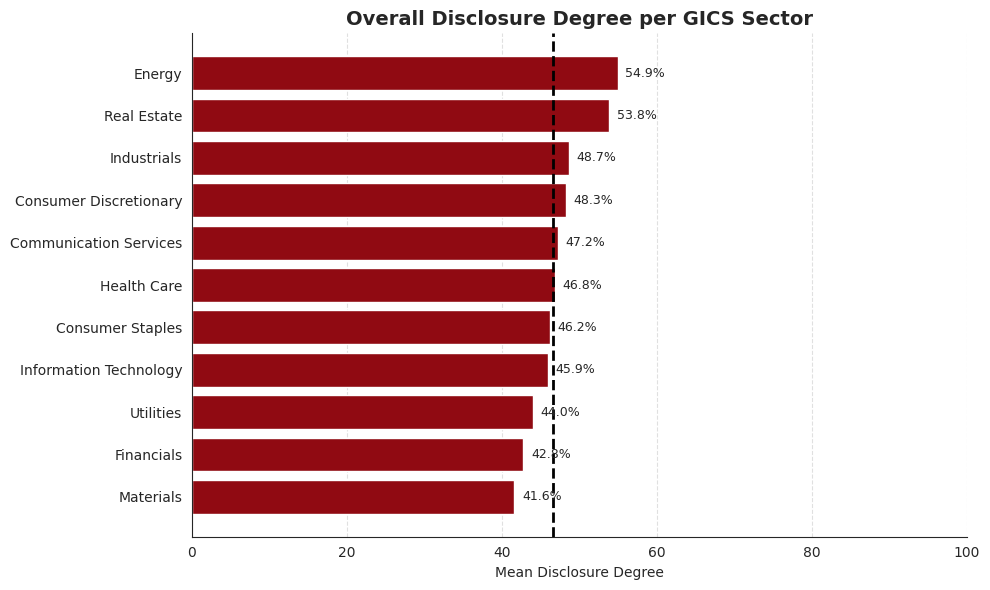

In [33]:
# --- Calculate mean disclosure per GICS sector ---
sector_means = (
    aggregated_disclosure.groupby("GICS Sector Name")["report_disclosure"]
    .mean()
    .sort_values(ascending=False)
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(sector_means.index, sector_means.values, color="#900A12")

# --- Add data labels ---
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%", va="center", ha="left", fontsize=9)
    
# --- Add line for overall mean ---
overall_mean = aggregated_disclosure["report_disclosure"].mean()
ax.axvline(overall_mean, color="black", linestyle="--", linewidth=2)

# --- Layout ---    
ax.set_xlim(0, 100)
ax.set_xlabel("Mean Disclosure Degree")
ax.set_title("Overall Disclosure Degree per GICS Sector", fontsize=14, weight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.invert_yaxis()  # Höchster Wert oben

plt.tight_layout()
plt.show()


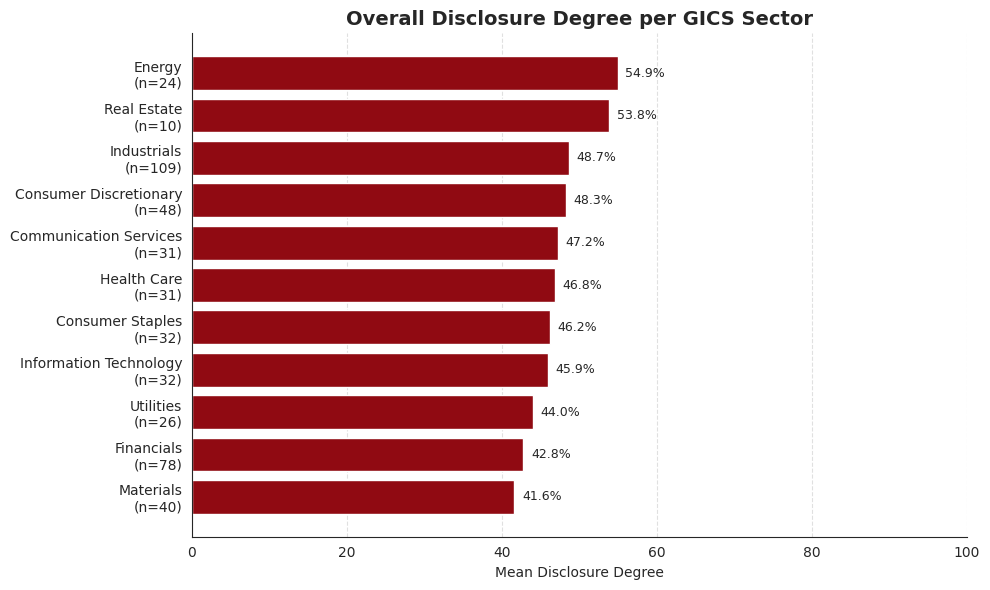

In [34]:
# --- Mean and count per sector ---
sector_stats = (
    aggregated_disclosure.groupby("GICS Sector Name")["report_disclosure"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=False)
)

# --- Create labels like: "Consumer Goods\n(n=15)" ---
sector_labels = [f"{sector}\n(n={count})" for sector, count in zip(sector_stats.index, sector_stats["count"])]

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(sector_labels, sector_stats["mean"], color="#900A12")

# --- Add values at the end of bars ---
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%", va="center", ha="left", fontsize=9)

# --- Layout ---
ax.set_xlim(0, 100)
ax.set_xlabel("Mean Disclosure Degree")
ax.set_title("Overall Disclosure Degree per GICS Sector", fontsize=14, weight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.invert_yaxis()  # highest value on top

plt.tight_layout()
plt.show()


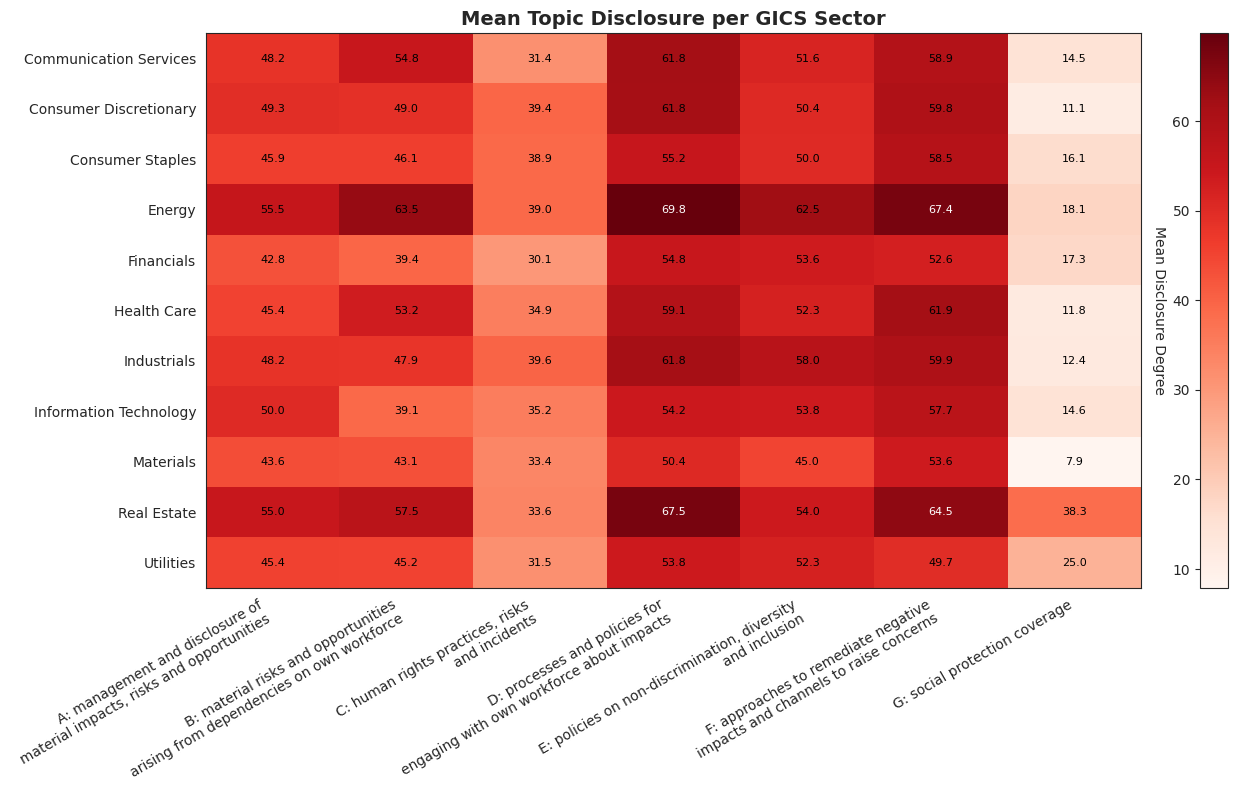

In [35]:
# --- Mean per sector and topic ---
topic_cols = ["A_disclosure", "B_disclosure", "C_disclosure", 
              "D_disclosure", "E_disclosure", "F_disclosure", "G_disclosure"]

sector_topic_means = (
    aggregated_disclosure.groupby("GICS Sector Name")[topic_cols]
    .mean()
    .sort_index()
)

# --- Heatmap-Plot ---
fig, ax = plt.subplots(figsize=(14, 8))
cmap = cm.Reds
im = ax.imshow(sector_topic_means, cmap=cmap, aspect="auto")

# Function to split strings after n words
def split_label(label, n_words=5):
    words = label.split()
    if len(words) > n_words:
        return ' '.join(words[:n_words]) + '\n' + ' '.join(words[n_words:])
    return label

# --- Axes labels with split topic_labels ---
split_topic_labels = [split_label(topic_labels[col]) for col in topic_cols]
ax.set_xticks(range(len(topic_cols)))
ax.set_xticklabels(split_topic_labels, rotation=30, ha="right", fontsize=10)

ax.set_yticks(range(len(sector_topic_means.index)))
ax.set_yticklabels(sector_topic_means.index)

# --- Colorbar ---
cbar = plt.colorbar(im, ax=ax)
cbar.ax.yaxis.set_label_position("left")   # move label to the left
cbar.ax.yaxis.tick_left()
cbar.set_label("Mean Disclosure Degree", rotation=-90, labelpad=15)  # flip label direction

# --- Write values into the cells ---
for i in range(sector_topic_means.shape[0]):
    for j in range(sector_topic_means.shape[1]):
        value = sector_topic_means.iloc[i, j]
        text_color = "white" if value > 64 else "black"
        ax.text(j, i, f"{value:.1f}", ha="center", va="center", color=text_color, fontsize=8)

# --- Titel & Layout ---
ax.set_title("Mean Topic Disclosure per GICS Sector", fontsize=14, weight="bold")

plt.tight_layout()
plt.show()


## 4. by size

/tmp/ipykernel_2036490/4162026914.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2036490/4162026914.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2036490/4162026914.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


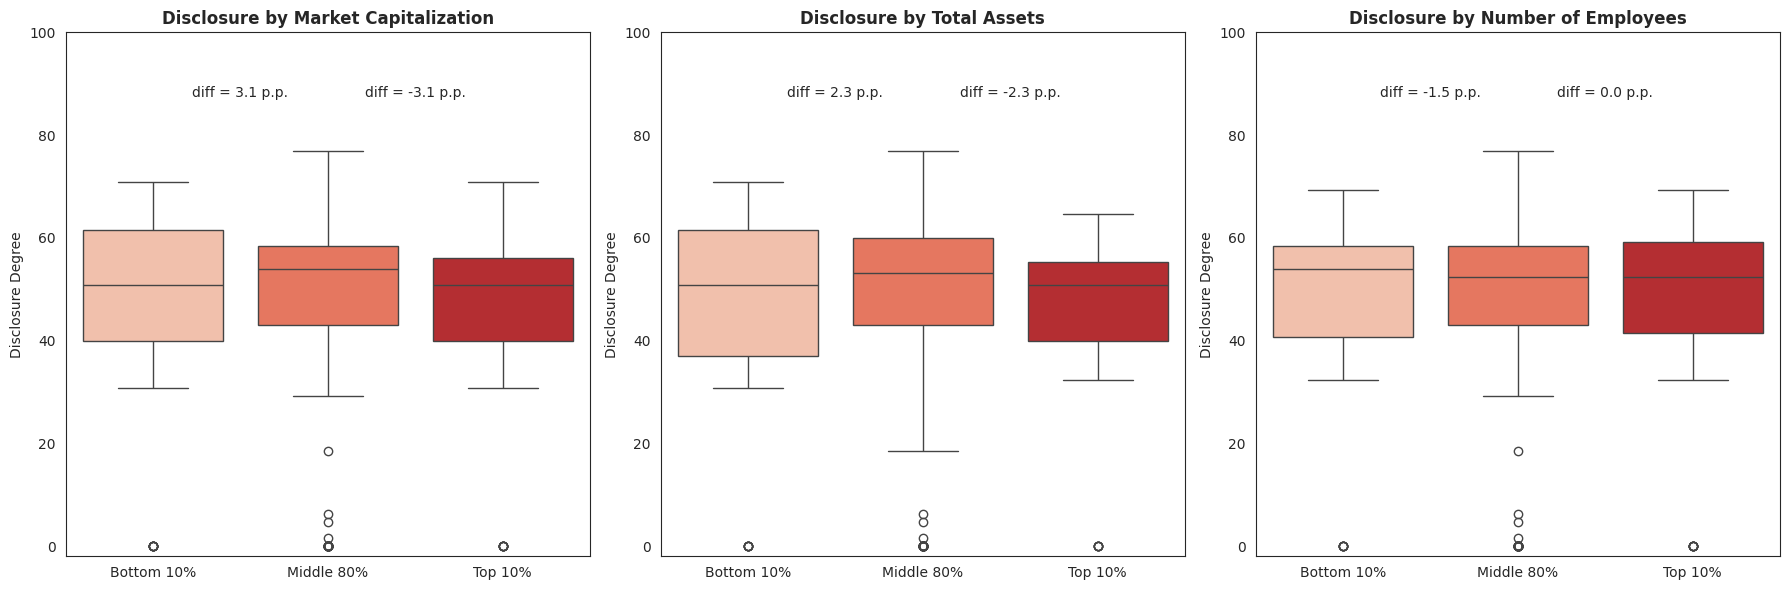

In [37]:
# --- Create Bottom 10%, Middle 80%, Top 10% groups ---
size_metrics = {
    "Market Capitalization": "Company Market Capitalization",
    "Total Assets": "Total Assets - Mean",
    "Number of Employees": "number_employees"
}

plot_df = pd.DataFrame()

for label, col in size_metrics.items():
    bottom_10 = aggregated_disclosure[aggregated_disclosure[col] <= aggregated_disclosure[col].quantile(0.1)].copy()
    top_10 = aggregated_disclosure[aggregated_disclosure[col] >= aggregated_disclosure[col].quantile(0.9)].copy()
    middle_80 = aggregated_disclosure[
        (aggregated_disclosure[col] > aggregated_disclosure[col].quantile(0.1)) & 
        (aggregated_disclosure[col] < aggregated_disclosure[col].quantile(0.9))
    ].copy()

    bottom_10['Group'] = 'Bottom 10%'
    middle_80['Group'] = 'Middle 80%'
    top_10['Group'] = 'Top 10%'

    temp_df = pd.concat([bottom_10, middle_80, top_10])
    temp_df['Metric'] = label
    plot_df = pd.concat([plot_df, temp_df])

# --- Plot Boxplots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (label, col) in zip(axes, size_metrics.items()):
    subset = plot_df[plot_df['Metric'] == label]
    
    sns.boxplot(
        x='Group',
        y='report_disclosure',
        data=subset,
        palette="Reds",
        ax=ax
    )
    ax.set_ylim(-2, 100)
    ax.set_title(f"Disclosure by {label}", fontsize=12, weight="bold")
    ax.set_ylabel("Disclosure Degree")
    ax.set_xlabel("")
    
    # --- Optional: Annotate differences ---
    groups = ['Bottom 10%', 'Middle 80%', 'Top 10%']
    for i in range(len(groups)-1):
        data1 = subset[subset['Group'] == groups[i]]['report_disclosure']
        data2 = subset[subset['Group'] == groups[i+1]]['report_disclosure']
        diff = round(data2.median() - data1.median(), 1)
        t_stat, p_val = ttest_ind(data2, data1)
        if p_val < 0.001:
            significance = '***'
        elif p_val < 0.01:
            significance = '**'
        elif p_val < 0.05:
            significance = '*'
        else:
            significance = ''
        
        ax.text(i + 0.5, max(subset['report_disclosure']) + 10, f"diff = {diff} p.p.{significance}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2036490/2311366484.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2036490/2311366484.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


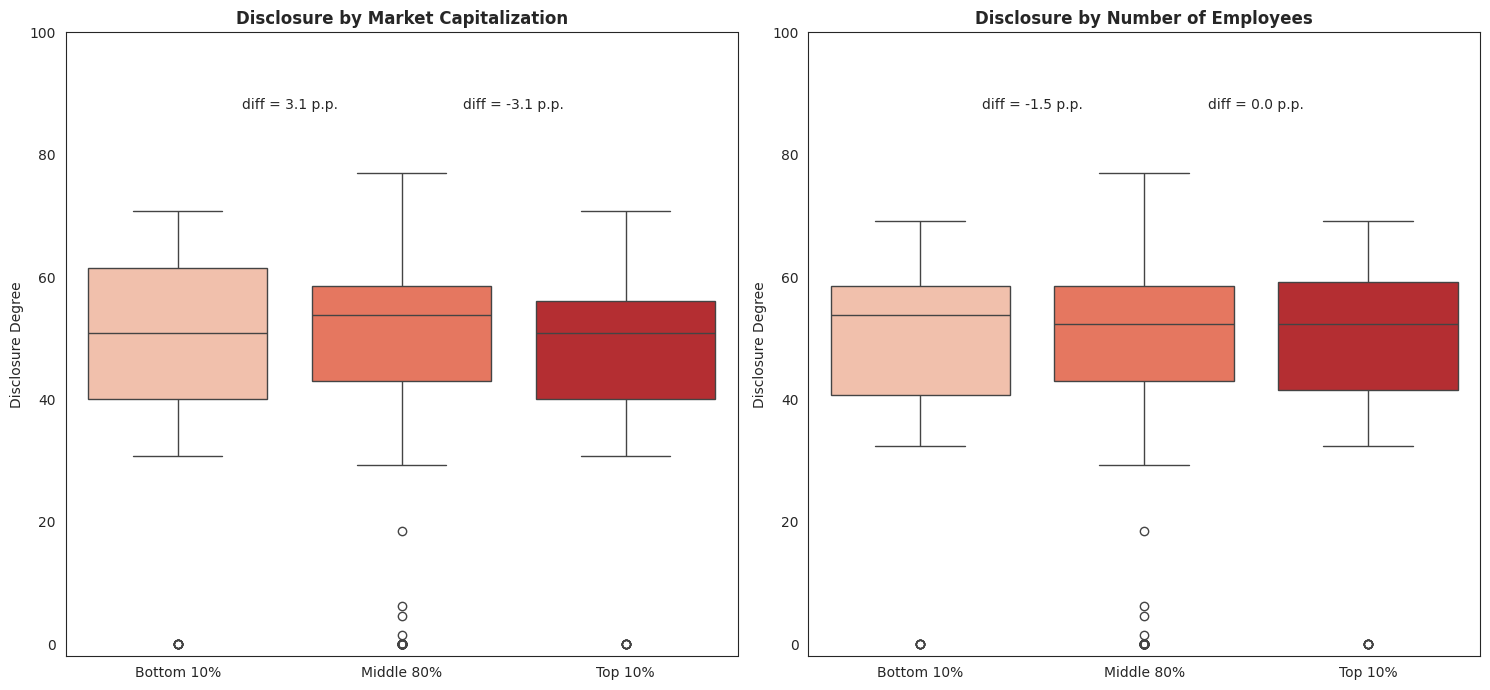

In [46]:
# --- Create Bottom 10%, Middle 80%, Top 10% groups ---
size_metrics = {
    "Market Capitalization": "Company Market Capitalization",
    "Number of Employees": "number_employees"
}


# --- Plot Boxplots ---
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for ax, (label, col) in zip(axes, size_metrics.items()):
    subset = plot_df[plot_df['Metric'] == label]
    
    sns.boxplot(
        x='Group',
        y='report_disclosure',
        data=subset,
        palette="Reds",
        ax=ax
    )
    ax.set_ylim(-2, 100)
    ax.set_title(f"Disclosure by {label}", fontsize=12, weight="bold")
    ax.set_ylabel("Disclosure Degree")
    ax.set_xlabel("")
    
    # --- Optional: Annotate differences ---
    groups = ['Bottom 10%', 'Middle 80%', 'Top 10%']
    for i in range(len(groups)-1):
        data1 = subset[subset['Group'] == groups[i]]['report_disclosure']
        data2 = subset[subset['Group'] == groups[i+1]]['report_disclosure']
        diff = round(data2.median() - data1.median(), 1)
        t_stat, p_val = ttest_ind(data2, data1)
        if p_val < 0.001:
            significance = '***'
        elif p_val < 0.01:
            significance = '**'
        elif p_val < 0.05:
            significance = '*'
        else:
            significance = ''
        
        ax.text(i + 0.5, max(subset['report_disclosure']) + 10, f"diff = {diff} p.p.{significance}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 5. in relation with LSEG ESG scores

/tmp/ipykernel_2036490/2347824045.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2036490/2347824045.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


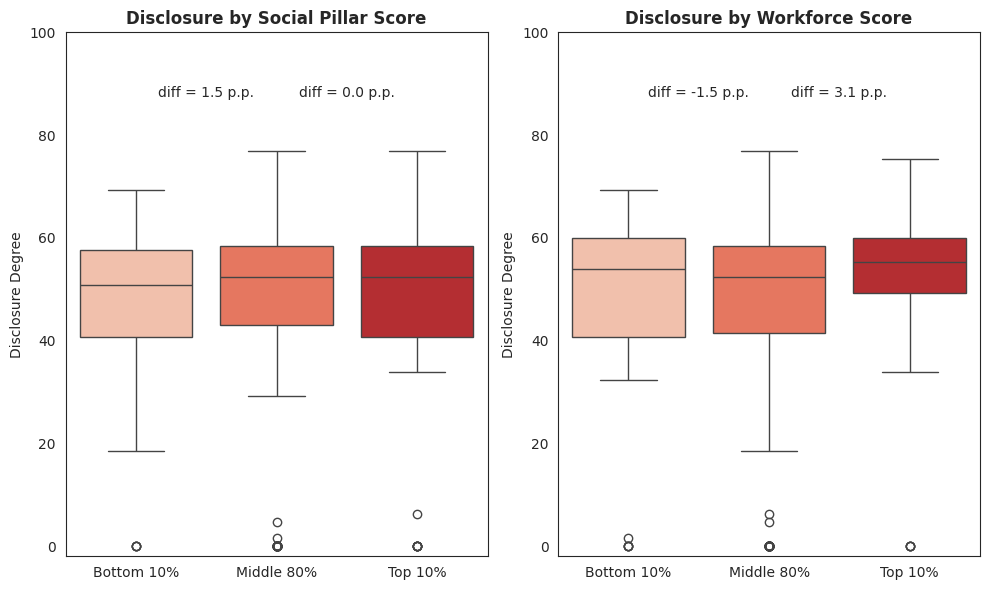

In [55]:
# --- Create Bottom 10%, Middle 80%, Top 10% groups ---
lseg_metrics = {
    "Social Pillar Score": "Social Pillar Score",
    "Workforce Score": "Workforce Score"
}

plot_df = pd.DataFrame()

for label, col in lseg_metrics.items():
    bottom_10 = aggregated_disclosure[aggregated_disclosure[col] <= aggregated_disclosure[col].quantile(0.1)].copy()
    top_10 = aggregated_disclosure[aggregated_disclosure[col] >= aggregated_disclosure[col].quantile(0.9)].copy()
    middle_80 = aggregated_disclosure[
        (aggregated_disclosure[col] > aggregated_disclosure[col].quantile(0.1)) & 
        (aggregated_disclosure[col] < aggregated_disclosure[col].quantile(0.9))
    ].copy()

    bottom_10['Group'] = 'Bottom 10%'
    middle_80['Group'] = 'Middle 80%'
    top_10['Group'] = 'Top 10%'

    temp_df = pd.concat([bottom_10, middle_80, top_10])
    temp_df['Metric'] = label
    plot_df = pd.concat([plot_df, temp_df])



# --- Plot Boxplots ---
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

for ax, (label, col) in zip(axes, lseg_metrics.items()):
    subset = plot_df[plot_df['Metric'] == label]
    
    sns.boxplot(
        x='Group',
        y='report_disclosure',
        data=subset,
        palette="Reds",
        ax=ax
    )
    ax.set_ylim(-2, 100)
    ax.set_title(f"Disclosure by {label}", fontsize=12, weight="bold")
    ax.set_ylabel("Disclosure Degree")
    ax.set_xlabel("")
    
    # --- Optional: Annotate differences ---
    groups = ['Bottom 10%', 'Middle 80%', 'Top 10%']
    for i in range(len(groups)-1):
        data1 = subset[subset['Group'] == groups[i]]['report_disclosure']
        data2 = subset[subset['Group'] == groups[i+1]]['report_disclosure']
        diff = round(data2.median() - data1.median(), 1)
        t_stat, p_val = ttest_ind(data2, data1)
        if p_val < 0.001:
            significance = '***'
        elif p_val < 0.01:
            significance = '**'
        elif p_val < 0.05:
            significance = '*'
        else:
            significance = ''
        
        ax.text(i + 0.5, max(subset['report_disclosure']) + 10, f"diff = {diff} p.p.{significance}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [50]:
print(plot_df['Metric'].unique())


['Market Capitalization' 'Total Assets' 'Number of Employees']


/tmp/ipykernel_2036490/28378071.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2036490/28378071.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2036490/28378071.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


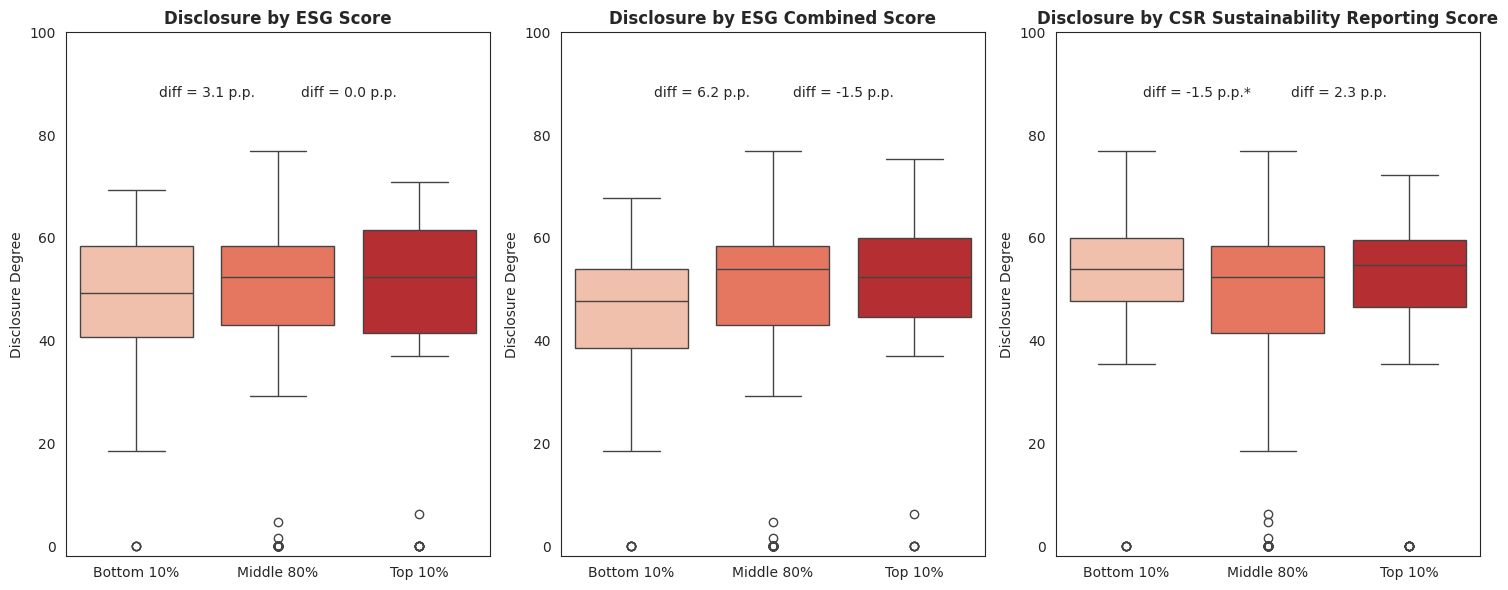

In [58]:
# --- Create Bottom 10%, Middle 80%, Top 10% groups ---
lseg_metrics = {
    "ESG Score": "ESG Score",
    "ESG Combined Score": "ESG Combined Score",
    "CSR Sustainability Reporting Score": "CSR Sustainability Reporting Score"
}


plot_df = pd.DataFrame()

for label, col in lseg_metrics.items():
    bottom_10 = aggregated_disclosure[aggregated_disclosure[col] <= aggregated_disclosure[col].quantile(0.1)].copy()
    top_10 = aggregated_disclosure[aggregated_disclosure[col] >= aggregated_disclosure[col].quantile(0.9)].copy()
    middle_80 = aggregated_disclosure[
        (aggregated_disclosure[col] > aggregated_disclosure[col].quantile(0.1)) & 
        (aggregated_disclosure[col] < aggregated_disclosure[col].quantile(0.9))
    ].copy()

    bottom_10['Group'] = 'Bottom 10%'
    middle_80['Group'] = 'Middle 80%'
    top_10['Group'] = 'Top 10%'

    temp_df = pd.concat([bottom_10, middle_80, top_10])
    temp_df['Metric'] = label
    plot_df = pd.concat([plot_df, temp_df])

# --- Plot Violin plots with embedded Boxplots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, (label, col) in zip(axes, size_metrics.items()):
    subset = plot_df[plot_df['Metric'] == label]
    
    sns.boxplot(
        x='Group',
        y='report_disclosure',
        data=subset,
        palette="Reds",
        ax=ax
    )
    ax.set_ylim(-2, 100)
    ax.set_title(f"Disclosure by {label}", fontsize=12, weight="bold")
    ax.set_ylabel("Disclosure Degree")
    ax.set_xlabel("")
    
    # --- Optional: Annotate differences ---
    groups = ['Bottom 10%', 'Middle 80%', 'Top 10%']
    for i in range(len(groups)-1):
        data1 = subset[subset['Group'] == groups[i]]['report_disclosure']
        data2 = subset[subset['Group'] == groups[i+1]]['report_disclosure']
        diff = round(data2.median() - data1.median(), 1)
        t_stat, p_val = ttest_ind(data2, data1)
        if p_val < 0.001:
            significance = '***'
        elif p_val < 0.01:
            significance = '**'
        elif p_val < 0.05:
            significance = '*'
        else:
            significance = ''
        
        ax.text(i + 0.5, max(subset['report_disclosure']) + 10, f"diff = {diff} p.p.{significance}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

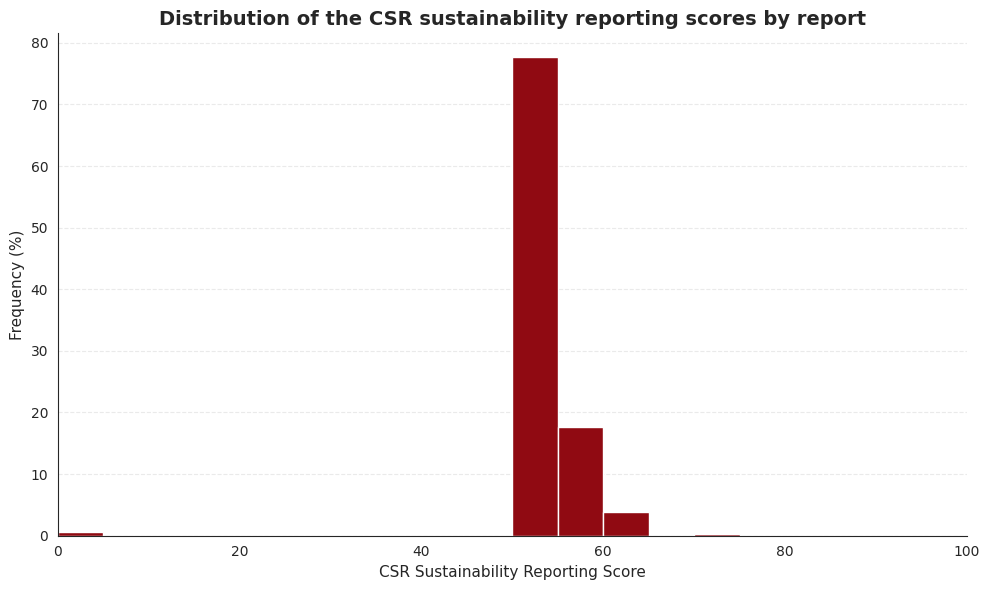

In [52]:
# --- Data ---
data = aggregated_disclosure["CSR Sustainability Reporting Score"].dropna()

# --- Style setup to match the bar chart ---
sns.set_style("white")  # remove gray Seaborn background

fig, ax = plt.subplots(figsize=(10, 6))

# --- Histogram with relative frequency in % ---
sns.histplot(
    data,
    bins=15,
    stat="percent",      # show relative frequencies
    color="#900A12",     # same as overall disclosure color
    alpha=1.0,
    edgecolor="white",   # clean bar separation
    ax=ax
)

# --- Layout and aesthetics to match ---
ax.set_xlim(0, 100)
ax.set_xlabel("CSR Sustainability Reporting Score", fontsize=11)
ax.set_ylabel("Frequency (%)", fontsize=11)
ax.set_title("Distribution of the CSR sustainability reporting scores by report", fontsize=14, weight="bold")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_facecolor("white")

plt.tight_layout()
plt.show()

                                Score  Correlation
0                 Social Pillar Score    -0.008779
1                     Workforce Score    -0.001787
2                           ESG Score     0.007202
3                  ESG Combined Score     0.046159
4  CSR Sustainability Reporting Score     0.012308


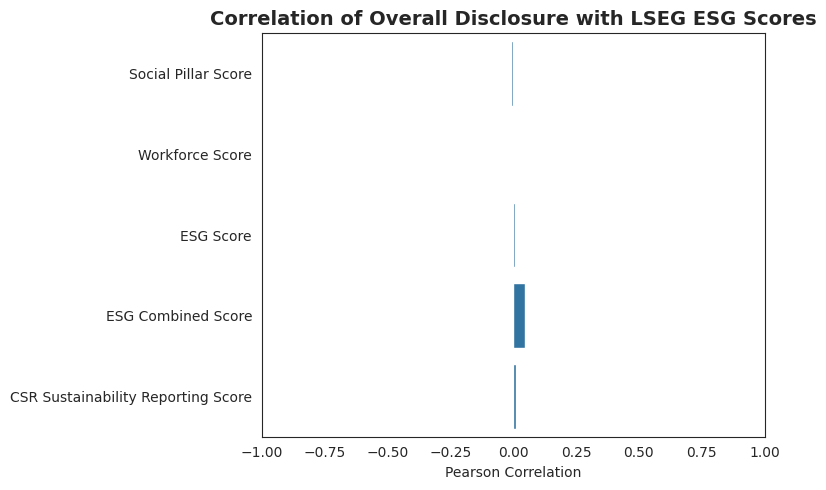

In [53]:
# --- Define the columns to correlate with overall_disclosure ---
scores = ["Social Pillar Score", "Workforce Score", "ESG Score", "ESG Combined Score", "CSR Sustainability Reporting Score"]

# --- Compute correlations ---
correlations = {}
for score in scores:
    corr = aggregated_disclosure["report_disclosure"].corr(aggregated_disclosure[score])
    correlations[score] = corr

# Convert to DataFrame for easy plotting
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).reset_index()
corr_df.rename(columns={'index': 'Score'}, inplace=True)

# --- Step 3: Display results ---
print(corr_df)

# --- Optional: visualize as bar plot ---
plt.figure(figsize=(8, 5))
sns.barplot(x='Correlation', y='Score', data=corr_df)
plt.xlim(-1, 1)
plt.title("Correlation of Overall Disclosure with LSEG ESG Scores", fontsize=14, weight="bold")
plt.xlabel("Pearson Correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()
